In [0]:
!pip install scprep

     |████████████████████████████████| 102kB 2.7MB/s 


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import colors, cm

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()

Saving PatientRoute.csv to PatientRoute.csv


In [0]:
import pandas as pd
import io
df = pd.read_csv('PatientRoute.csv')
df['global_num'] -= 1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [0]:
df

,patient_id,global_num,date,province,city,latitude,longitude
0,1400000001,0,2020-01-19,Incheon,Jung-gu,37.460459,126.440680
1,1400000001,0,2020-01-20,Incheon,Seo-gu,37.478832,126.668558
2,1000000001,1,2020-01-22,Gyeonggi-do,Gimpo-si,37.562143,126.801884
3,1000000001,1,2020-01-23,Seoul,Jung-gu,37.567454,127.005627
4,2000000001,2,2020-01-20,Incheon,Jung-gu,37.460459,126.440680
...,...,...,...,...,...,...,...
170,1200000031,30,2020-02-09,Daegu,Nam-gu,35.839820,128.566600
171,1200000031,30,2020-02-15,Daegu,Dong-gu,35.882410,128.662100
172,1200000031,30,2020-02-16,Daegu,Nam-gu,35.839820,128.566600
173,1200000031,30,2020-02-17,Daegu,Suseong-gu,35.844730,128.612300


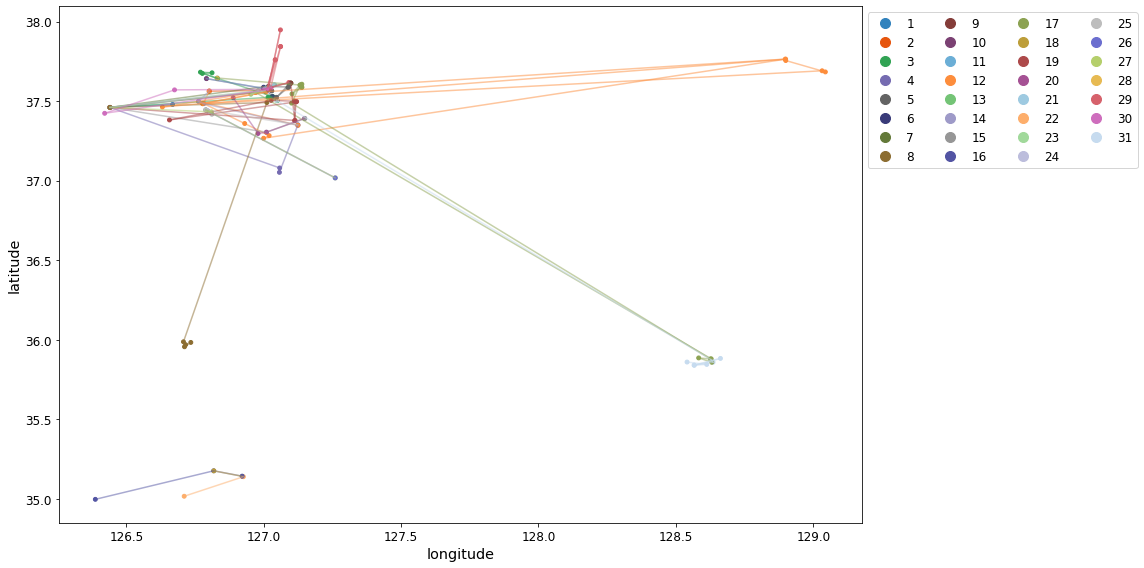

In [0]:
import scprep
colors = scprep.plot.colors.tab(len(np.unique(df['global_num']))).colors
cmap = {patient:colors[i] for i, patient in enumerate(np.unique(df['global_num']))}
ax = scprep.plot.scatter(x = df['longitude'], y=df['latitude'], c=df['global_num'], cmap=cmap,
                         legend_anchor=(1,1), figsize=(16,8), discrete=True)
for patient in np.unique(df['global_num']):
  plot_df = df.loc[df['global_num']==patient].sort_values('date')
  for i in range(plot_df.shape[0]-1):
    ax.plot(plot_df.iloc[[i,i+1]]['longitude'], plot_df.iloc[[i,i+1]]['latitude'], color=cmap[patient], alpha=0.5)

## Contact graph

In [0]:
from scipy.spatial.distance import pdist, squareform
def dist(i, j):
  df_i = df.loc[df['global_num'] == i]
  df_j = df.loc[df['global_num'] == j]
  min_dist = np.float64('inf')
  for _, x in df_i.iterrows():
    for _, y in df_j.iterrows():
      d = np.sqrt(np.sum((x[['latitude', 'longitude']] - y[['latitude', 'longitude']])**2))
      if d < min_dist:
        min_dist = d
  return min_dist
D = np.array([[dist(i, j) for i in np.unique(df['global_num'])] for j in np.unique(df['global_num'])])

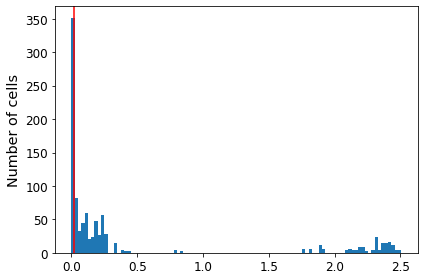

In [0]:
scprep.plot.histogram(D.flatten()[np.isfinite(D.flatten())], cutoff=0.02)

In [0]:
!pip install pygsp

     |████████████████████████████████| 1.8MB 2.8MB/s 


In [0]:
import pygsp
W = D < 0.02
G = pygsp.graphs.Graph(W, gtype='ROK Contact Map')
G.set_coordinates()

2020-03-25 18:02:51,906:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


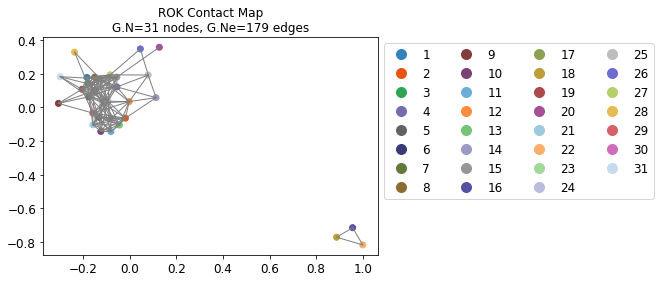

In [0]:
fig, ax = plt.subplots()
pygsp.plotting.plot_graph(G, show_edges=True, vertex_size=0.01, ax=ax)
scprep.plot.scatter2d(G.coords, c=np.unique(df['global_num']), legend_anchor=(1,1), ax=ax, discrete=True)

In [0]:
#let's say N of the G people were infected
#then go to the locations of these N people
#lets say each infected person i had contact with Ci people
#then each infected person increases the risk in their region by k*Ci
#so we can make a heatmap of the k*Ci! 

In [0]:
#ok let's try this. Let's say people 1, 6, 11, 16 and 21 are infected 
infected_num = [1, 6, 11, 16, 21]

In [0]:
dates = np.unique(df['date'])
patients = np.unique(df['global_num'])

In [0]:
dates, patients

(array(['2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22',
        '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
        '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
        '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03',
        '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
        '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11',
        '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15',
        '2020-02-16', '2020-02-17', '2020-02-18'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]))

In [0]:
state = np.zeros((len(dates), len(patients)))
state[0,infected_num] = 1

![schematic](https://covid-measures.github.io/model_schematic.png)

Parameters of interest: 

* $R_0$: number of expected secondary cases in a wholly susceptible population.
* $\gamma$: 1/time for which a patient is infectious
* $\beta_0 = R_0 \times \gamma$: transmissibility, or people infected by patient per day
* $\alpha$: percentage of cases that are asymptomatic
* $\lambda_p$: 1/time before symptoms appear
* $\lambda_a$: 1/time for asymptomatic to recover
* $\lambda_m$: 1/time for minorly symptomatic to recover
* $\lambda_s$: 1/time for severely symptomatic to be hospitalized
* $\rho$: 1/time for leaving hospital
* $\delta$: fraction of hospitalizations leading to death
* $\mu$: fraction of symptomatic cases which do not require hospitalization



Parameter estimates: 

* $1.6 < R_0 < 2.3$
* $\gamma = \frac{1}{7}$ or...
* $0.3299 < \beta_0 < 0.371$
* $0.308 < \alpha < 0.517$
* $\lambda_p = 2$
* $\lambda_a = 0.1429$
* $\lambda_m = 0.1429$
* $\lambda_s = 0.1736$
* $0.0689< \rho < 0.087$
* $0.14 < \delta < 0.33$
* $\mu = 0.956$

Sources: 
* [Marissa Childs, Morgan Kain, Devin Kirk, Mallory Harris, Jacob Ritchie, Lisa Couper, Isabel Delwel, Nicole Nova, Erin Mordecai](https://github.com/morgankain/COVID_interventions/blob/master/covid_params.csv)
* [Paige Miller, Pej Rohani, John Drake](http://2019-coronavirus-tracker.com/parameters-supplement.html)

### HMM Specification

Let $N_c$ be the average number of interactions each person has in a day, $N_0$ be the population, $N_i$ be the number of infectious people. Then naively,

$$P(E(t+1) | S(t)) = \frac{N_c N_i}{N_0}.$$

Note: we will actually determine this based on contacts with infected people. So

$$P(E(t+1) | S(t)) = 1 - \prod_{\text{patient }i}(1 - P(\text{contact with patient }i) P(\text{patient }i\text{ infectious})).$$

The probability of transmitting the disease on contact is

$$P(I_A(t+1) \text{ or } I_P(t+1) | E(t)) = \frac{\beta_0}{N_c}$$

and otherwise, a person remains susceptible

$$P(S(t+1) | E(t)) = 1-\frac{\beta_0}{N_c}.$$

We treat appearance of symptoms and recovery as geometrically distributed with $p = \frac{\lambda}{1+\lambda}$. So

$$P(I_P(t+1)|I_P(t)) = 1-\lambda_p$$
$$P(I_A(t+1)|I_A(t)) = 1-\lambda_a$$
$$P(I_M(t+1)|I_M(t)) = 1-\lambda_m$$
$$P(I_S(t+1)|I_S(t)) = 1-\lambda_s$$
$$P(H(t+1)|H(t)) = 1-\rho.$$

Finally, the remaining transition probabilities are defined as follows:

$$P(I_A(t+1) | I_A(t+1) \text{ or } I_P(t+1)) = \alpha$$

$$P(I_P(t+1) | I_A(t+1) \text{ or } I_P(t+1)) = 1 - \alpha$$

and 

$$P(I_M(t+1) | I_P(t) \text{ and not } I_P(t+1)) = \mu$$

$$P(I_S(t+1) | I_P(t) \text{ and not } I_P(t+1)) = 1 - \mu$$

and

$$P(D(t+1) | H(t) \text{ and not } H(t+1)) = \delta$$

$$P(R(t+1) | H(t) \text{ and not } H(t+1)) = 1-\delta.$$


In [0]:
state_dict = {0:'S', 1:'E', 2:'I_A', 3:'I_P', 4:'I_M', 5:'I_S', 6:'H', 7:'R', 8:'D'}
#susceptible, exposed, asymptomatic, presymptomatic, mild, severe, hospitalised, recovered, dead
infectious_states = [2,3,4,5]

In [0]:
transitions = np.zeros((len(state_dict), len(state_dict)))

In [0]:
N_0 = len(patients) #starting number of infected cases
N_c = 4             #average number of contacts per day
beta0 = 0.35        #people infected by patient per day
alpha = 0.4         #fraction of cases that are asymptomatic
lambda_p = 1 # 2?   #1/(days till symptoms appear)
lambda_a = 0.1429   #1/(days till asymptomatic person recovers)
lambda_m = 0.1429   #1/(days till mild case recovers)
lambda_s = 0.1736   #1/(days till severe case is hospitalised)
rho = 0.075         #1/(days in hospital)
delta = 0.2         #number of deaths/number hospitalised
mu = 0.9#0.956      #fraction of symptomatic cases that don't need hospitalisation

### Random simulation

In [0]:
state = np.zeros((len(patients), len(state_dict)))
state[~np.isin(np.arange(len(patients)), infected_num), 0]=1
state[infected_num, 2]=alpha
state[infected_num, 3]=(1-alpha) * mu
state[infected_num, 4]=(1-alpha) * (1-mu)
state.round(2)

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.4 , 0.54, 0.06, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.4 , 0.54, 0.06, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.4 , 0.54, 0.06, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,

In [0]:
N_i = np.sum(state[:,infectious_states])

transitions[0,0] = 1 - N_c * N_i / N_0        # S -> S
transitions[0,1] = N_c * N_i / N_0            # S -> E
transitions[1,0] = 1 - beta0 / N_c            # E -> S
transitions[1,2] = alpha * beta0 / N_c        # E -> I_A
transitions[1,3] = (1 - alpha) * beta0 / N_c  # E -> I_P
transitions[2,2] = 1 - lambda_a               # I_A -> I_A
transitions[2,7] = lambda_a                   # I_A -> R
transitions[3,3] = 1 - lambda_p               # I_P -> I_P
transitions[3,4] = mu * lambda_p              # I_P -> I_M
transitions[3,5] = (1-mu) * lambda_p          # I_P -> I_S
transitions[4,4] = 1 - lambda_m               # I_M -> I_M
transitions[4,7] = lambda_m                   # I_M -> R
transitions[5,5] = 1 - lambda_s               # I_S -> I_S
transitions[5,6] = lambda_s                   # I_S -> H
transitions[6,6] = 1 - rho                    # H -> H
transitions[6,7] = (1 - delta) * rho          # H -> R
transitions[6,8] = delta * rho                # H -> D
transitions[7,7] = 1                          # R -> R
transitions[8,8] = 1                          # D -> D

transitions.round(2)

array([[0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.91, 0.  , 0.03, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.86, 0.  , 0.  , 0.  , 0.  , 0.14, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.9 , 0.1 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.86, 0.  , 0.  , 0.14, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.83, 0.17, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.92, 0.06, 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [0]:
state = state @ transitions
N_i = np.sum(state[:,infectious_states])
transitions[0,0] = 1 - N_c * N_i / N_0 # S -> S
transitions[0,1] = N_c * N_i / N_0 # S -> E
N_i

4.67133

In [0]:
state.round(2)

array([[0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.34, 0.  , 0.54, 0.05, 0.  , 0.07, 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.34, 0.  , 0.54, 0.05, 0.  , 0.07, 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.34, 0.  , 0.54, 0.05, 0.  , 0.07, 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.65, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,

### Meetings-based simulation

In [0]:
from scipy.spatial.distance import cdist
distance_cutoff = 0.5#0.02

def daily_contacts(patient, date):
    date_df = df.loc[df['date'] == date]
    patient_df = date_df.loc[date_df['global_num'] == patient]
    if patient_df.shape[0] == 0:
      return []
    others_df = date_df.loc[date_df['global_num'] != patient]
    contact = cdist(patient_df[['latitude', 'longitude']], 
                    others_df[['latitude', 'longitude']]) < distance_cutoff
    contact = contact.max(axis=0)
    contact_patients = others_df.iloc[contact]['global_num'].to_numpy()
    return contact_patients

# Nc estimate
Nc = []
for date in dates:
  for patient in patients:
    Nc.append(len(daily_contacts(patient, date)))

Nc = np.mean(Nc)
Nc

0.41519250780437045

In [0]:
state = np.zeros((len(patients), len(state_dict)))
state[~np.isin(np.arange(len(patients)), infected_num), 0]=1
state[infected_num, 2]=alpha
state[infected_num, 3]=(1-alpha) * mu
state[infected_num, 4]=(1-alpha) * (1-mu)
state.round(2)

N_i = np.sum(state[:,infectious_states])

transitions[0,0] = 1 - N_c * N_i / N_0 # S -> S
transitions[0,1] = N_c * N_i / N_0 # S -> E
transitions[1,0] = 1 - beta0 / N_c # E -> S
transitions[1,2] = alpha * beta0 / N_c # E -> I_A
transitions[1,3] = (1 - alpha) * beta0 / N_c # E -> I_P
transitions[2,2] = 1 - lambda_a # I_A -> I_A
transitions[2,7] = lambda_a # I_A -> R
transitions[3,3] = 1 - lambda_p # I_P -> I_P
transitions[3,4] = mu * lambda_p # I_P -> I_M
transitions[3,5] = (1-mu) * lambda_p # I_P -> I_S
transitions[4,4] = 1 - lambda_m # I_M -> I_M
transitions[4,7] = lambda_m # I_M -> R
transitions[5,5] = 1 - lambda_s # I_S -> I_S
transitions[5,6] = lambda_s # I_S -> H
transitions[6,6] = 1 - rho # H -> H
transitions[6,7] = (1 - delta) * rho # H -> R
transitions[6,8] = delta * rho # H -> D
transitions[7,7] = 1 # R -> R
transitions[8,8] = 1 # D -> D

transitions.round(3)

array([[0.355, 0.645, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.912, 0.   , 0.035, 0.052, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.857, 0.   , 0.   , 0.   , 0.   , 0.143, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.9  , 0.1  , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.857, 0.   , 0.   , 0.143, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.826, 0.174, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.925, 0.06 , 0.015],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

In [0]:
def p_exposed(patient, date):
    contact_patients = daily_contacts(patient, date)
    if len(contact_patients) == 0:
      return 0
    p_contacts_infected = state[contact_patients][:,infectious_states].sum(1)
    p_exposed = 1 - np.prod(1 - p_contacts_infected)
    return p_exposed

for date in dates:
  next_state = state.copy()
  for patient in patients:
    transitions[0, 1] = p_exposed(patient, date)
    transitions[0, 0] = 1 - transitions[0, 1]
    next_state[patient] = state[[patient]] @ transitions
  state = next_state
print(state.round(3))

[[0.912 0.    0.    0.    0.001 0.    0.001 0.085 0.001]
 [0.    0.    0.003 0.    0.005 0.    0.009 0.973 0.009]
 [0.769 0.    0.002 0.    0.003 0.    0.003 0.221 0.002]
 [0.865 0.    0.001 0.    0.002 0.    0.002 0.129 0.001]
 [0.828 0.    0.003 0.    0.004 0.    0.003 0.16  0.001]
 [0.843 0.    0.002 0.    0.003 0.    0.003 0.148 0.001]
 [0.    0.    0.003 0.    0.005 0.    0.009 0.973 0.009]
 [0.869 0.    0.001 0.    0.002 0.    0.002 0.124 0.001]
 [0.979 0.    0.001 0.    0.001 0.    0.001 0.019 0.   ]
 [0.955 0.    0.001 0.    0.002 0.    0.001 0.041 0.   ]
 [0.955 0.    0.001 0.    0.002 0.    0.001 0.041 0.   ]
 [0.    0.    0.003 0.    0.005 0.    0.009 0.973 0.009]
 [0.99  0.    0.    0.    0.001 0.    0.    0.009 0.   ]
 [0.88  0.    0.001 0.    0.002 0.    0.002 0.114 0.001]
 [0.893 0.    0.001 0.    0.002 0.    0.002 0.1   0.001]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.003 0.    0.005 0.    0.009 0.973 0.009]
 [1.    0.    0.    0.    0.   

### Meetings, positive tests, hospitalisations and deaths

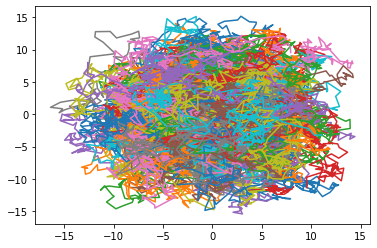

In [0]:
N0 = 200
T = 100
randomwalk = np.cumsum(np.random.normal(0, 1, (N0, T, 2)), axis=1)
initial_position = np.random.uniform(-10, 10, (N0, 2))[:,None]
randomwalk += initial_position
for t in range(T):
  randomwalk[:,t:] -= randomwalk[:,t:] * np.sqrt((randomwalk[:,t]**2).sum(1))[:,None,None] * 0.001
for i in range(N0):
  plt.plot(randomwalk[i][:,0], randomwalk[i][:,1])

In [0]:
location_df = pd.DataFrame({'patient':np.repeat(np.arange(N0), T),
                            'latitude':randomwalk[:,:,0].flatten(),
                            'longitude':randomwalk[:,:,1].flatten()})

,patient,latitude,longitude
0,0,1.514677,0.661774
1,0,2.202583,-1.269349
2,0,2.066212,-2.381369
3,0,1.317950,-2.509743
4,0,1.824212,-2.121246
...,...,...,...
495,9,1.979520,-0.155330
496,9,1.931593,0.235727
497,9,2.040718,0.342056
498,9,2.763340,0.318071


In [0]:
tests